In [1]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), 'src', 'python'))
from helper_functions import parser_input, print_atom_info, run_scf
import numpy as np
import matplotlib.pyplot as plt    
import pandas as pd
import ctypes


Constants

In [2]:
eps_scf = 1e-10
max_iter = 100
final_energy = ctypes.c_double()

Library definition

In [3]:
lib_path = os.path.join(os.getcwd() ,'build', 'libscf.dylib')
lib = ctypes.CDLL(lib_path)

lib.run_scf_interface_py.argtypes = [
    ctypes.c_int,                      # natoms
    ctypes.c_int,                      # nelectrons
    ctypes.POINTER(ctypes.c_int),      # atomic_numbers
    ctypes.POINTER(ctypes.c_double),   # coords
    ctypes.c_double,                   # eps_scf
    ctypes.c_int,                      # max_iter
    ctypes.POINTER(ctypes.c_double),   # final_energy
    ctypes.POINTER(ctypes.c_int),      # nbasis_atom
    ctypes.POINTER(ctypes.c_double)    # basis_exp
]


# $H_2$ internuclear study
Read input

In [4]:
molecule_pre = os.path.join(os.getcwd(), 'data','molecules/')
input_file = 'h2.in'

natoms, nelectrons, atomic_numbers, coords, nbasis_atom, basis_exp = parser_input(molecule_pre + input_file)

Distance investigation of $H_2$

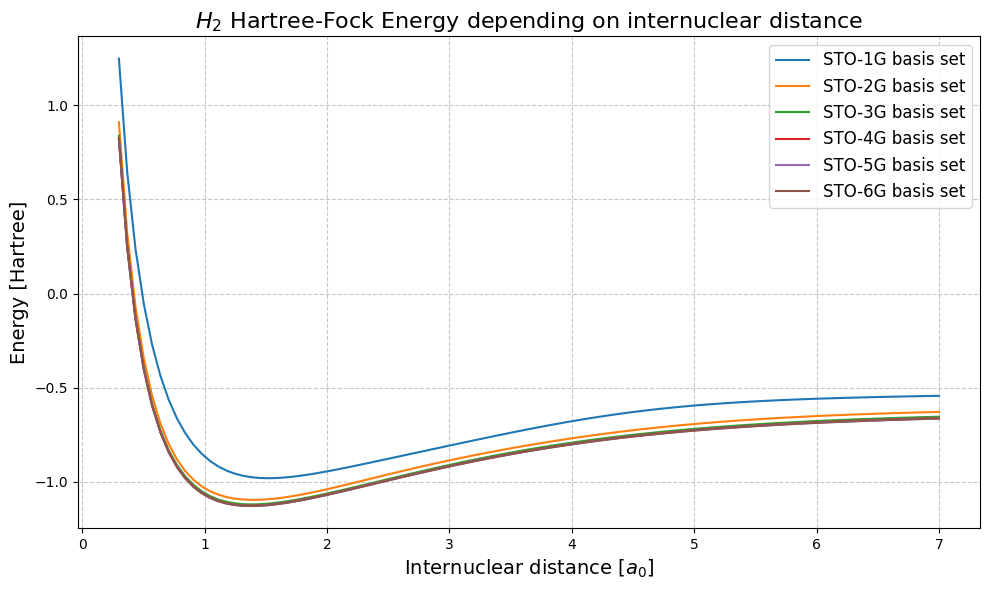

In [5]:
energies = []
distances = np.linspace(0.3, 7.0, 100)
for i in range(1, 7):
    energy_list = []
    for j in range(len(distances)):
        coords[0, 2] = distances[j]
        energy = run_scf(lib, natoms, nelectrons, atomic_numbers, coords, eps_scf, max_iter, nbasis_atom, basis_exp, basis_set = i)
        energy_list.append(energy)
    energies.append(energy_list)

plt.figure(figsize=(10, 6))  # Set the figure size
for i in range(1, 7):
    plt.plot(distances, energies[i-1], label=f'STO-{i}G basis set', linewidth=1.5)

plt.xlabel(r'Internuclear distance [$a_0$]', fontsize=14)
plt.ylabel(r'Energy [Hartree]', fontsize=14)
plt.title(r'$H_2$ Hartree-Fock Energy depending on internuclear distance', fontsize=16)
plt.legend(fontsize=12, loc='best')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



Minima study

In [6]:
# Find the minimum energy and corresponding distance for each basis set
min_values = []
for i in range(len(energies)):
    min_energy = min(energies[i])
    min_distance = distances[energies[i].index(min_energy)]
    min_values.append((f'STO-{i+1}G', min_distance, min_energy))

# Create a table to display the results
results_df = pd.DataFrame(min_values, columns=['Basis Set', 'Distance (a0)', 'Minimum Energy (Hartree)'])
print(results_df)

opt_distance_6g = results_df.loc[results_df['Basis Set'] == 'STO-6G', 'Distance (a0)'].values[0]
print('\nThe optimal distanc for the STO-6G set was:', opt_distance_6g)


  Basis Set  Distance (a0)  Minimum Energy (Hartree)
0    STO-1G       1.518182                 -0.980100
1    STO-2G       1.382828                 -1.094998
2    STO-3G       1.382828                 -1.119201
3    STO-4G       1.382828                 -1.125623
4    STO-5G       1.382828                 -1.127337
5    STO-6G       1.382828                 -1.127896

The optimal distanc for the STO-6G set was: 1.382828282828283


# $H_2$ Slater exponent study


In [7]:
coords = np.array([[0.0, 0.0, 0.0], [opt_distance_6g, 0.0, 0.0]])
slater_det = np.linspace(0.8, 1.9, 100)

energies = []
for i in range(len(slater_det)):
    part_energies = []
    for j in range(len(slater_det)):
        energy = run_scf(lib, natoms, nelectrons, atomic_numbers, coords, eps_scf, max_iter, nbasis_atom, [slater_det[i], slater_det[j]], basis_set = 6)
        part_energies.append(energy)
    energies.append(part_energies)


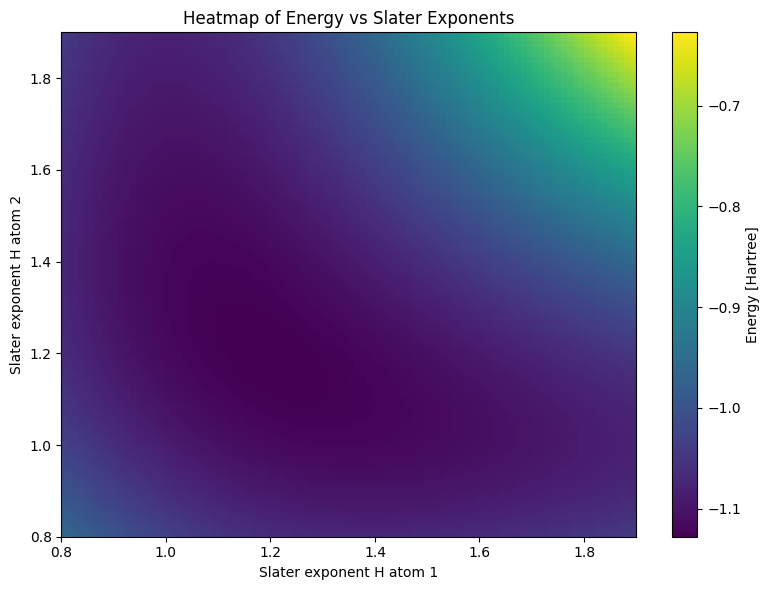

Minimum energy: -1.1279253257312678 Hartree
Slater exponent H atom 1: 1.1888888888888889
Slater exponent H atom 2: 1.2


In [8]:
# Convert energies to a 2D numpy array for heatmap plotting
energies_array = np.array(energies)

# Create the heatmap
plt.figure(figsize=(8, 6))
plt.imshow(energies_array, extent=[slater_det[0], slater_det[-1], slater_det[0], slater_det[-1]], origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(label='Energy [Hartree]')
plt.xlabel('Slater exponent H atom 1')
plt.ylabel('Slater exponent H atom 2')
plt.title('Heatmap of Energy vs Slater Exponents')
plt.tight_layout()
plt.show()

# Find the indices of the minimum energy in the grid
min_energy_index = np.unravel_index(np.argmin(energies_array), energies_array.shape)

# Extract the corresponding Slater exponents and minimum energy value
min_slater_exp_1 = slater_det[min_energy_index[0]]
min_slater_exp_2 = slater_det[min_energy_index[1]]
min_energy_value = energies_array[min_energy_index]

print(f"Minimum energy: {min_energy_value} Hartree")
print(f"Slater exponent H atom 1: {min_slater_exp_1}")
print(f"Slater exponent H atom 2: {min_slater_exp_2}")